<a href="https://colab.research.google.com/github/lievda01/adidas-pricing-analysis/blob/main/adidas_pricing_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Read the data

df = pd.read_excel('Adidas US Sales Datasets.xlsx', header=4)
df = df[df.columns[1:]]


In [3]:
df.head()

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
0,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50.0,1200,600000.0,300000.0,0.50,In-store
1,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,50.0,1000,500000.0,150000.0,0.30,In-store
2,Foot Locker,1185732,2020-01-03,Northeast,New York,New York,Women's Street Footwear,40.0,1000,400000.0,140000.0,0.35,In-store
3,Foot Locker,1185732,2020-01-04,Northeast,New York,New York,Women's Athletic Footwear,45.0,850,382500.0,133875.0,0.35,In-store
4,Foot Locker,1185732,2020-01-05,Northeast,New York,New York,Men's Apparel,60.0,900,540000.0,162000.0,0.30,In-store


In [4]:
#Load additional variables to capture seasonality and trend

dummies = pd.read_excel('Dummy Variables.xlsx')

trend = pd.read_csv('multiTimeline (1).csv')

In [5]:
#The following code seeks to organize the data at a weekly level to decrease some noise.

#Let's group days by week
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])

# Set "Invoice Date" to the Sunday ending of each week
df['Invoice Date'] = df['Invoice Date'] + pd.to_timedelta((6 - df['Invoice Date'].dt.dayofweek), unit='D')

#Group by weeks to decrease volatility
df = df.groupby(['Retailer', 'Region', 'State', 'City', 'Product', 'Sales Method', df['Invoice Date'].dt.to_period('W').dt.end_time.dt.date]).agg({
    'Price per Unit': 'mean',
    'Units Sold': 'sum',
    'Total Sales': 'sum'
})

df = df.reset_index()

In [6]:
df

,Retailer,Region,State,City,Product,Sales Method,Invoice Date,Price per Unit,Units Sold,Total Sales
0,Amazon,Midwest,Ohio,Columbus,Men's Apparel,Online,2021-01-24,48.0,252,102392.0
1,Amazon,Midwest,Ohio,Columbus,Men's Apparel,Online,2021-02-14,43.0,572,207502.0
2,Amazon,Midwest,Ohio,Columbus,Men's Apparel,Online,2021-03-14,38.5,488,154181.0
3,Amazon,Midwest,Ohio,Columbus,Men's Apparel,Online,2021-04-11,43.5,476,172992.0
4,Amazon,Midwest,Ohio,Columbus,Men's Apparel,Online,2021-05-09,49.5,576,231174.0
...,...,...,...,...,...,...,...,...,...,...
7661,West Gear,West,Washington,Seattle,Women's Street Footwear,Online,2020-07-05,78.0,175,13650.0
7662,West Gear,West,Washington,Seattle,Women's Street Footwear,Online,2020-07-12,73.0,163,11899.0
7663,West Gear,West,Washington,Seattle,Women's Street Footwear,Online,2020-07-19,63.0,135,8505.0
7664,West Gear,West,Washington,Seattle,Women's Street Footwear,Online,2020-07-26,56.0,113,6328.0


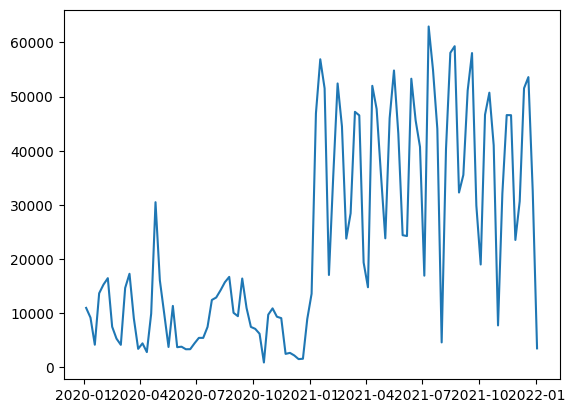

In [ ]:
plt.plot(df.groupby('Invoice Date')['Units Sold'].sum())

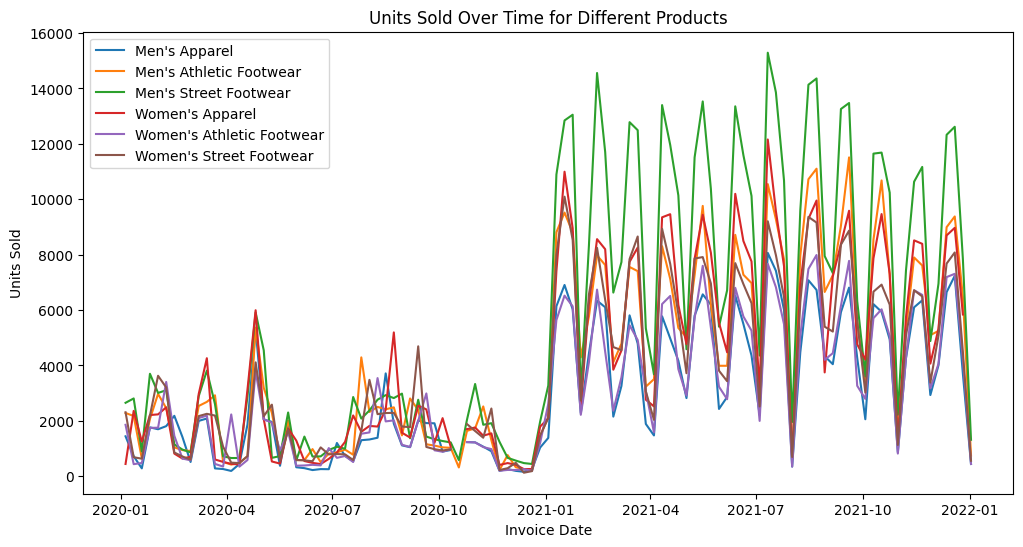

In [7]:
#The following plot will look at sales for each category over time to analyze the trend.

product_df = df[['Invoice Date','Product','Units Sold']]
product_df.sort_values(by='Invoice Date', ascending = True)

product_pivot = pd.pivot_table(product_df, index = 'Invoice Date', values = 'Units Sold', columns = 'Product', aggfunc='sum')

plt.figure(figsize=(12, 6))
for product in product_pivot.columns:
    plt.plot(product_pivot.index, product_pivot[product], label=product)

plt.title('Units Sold Over Time for Different Products')
plt.xlabel('Invoice Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

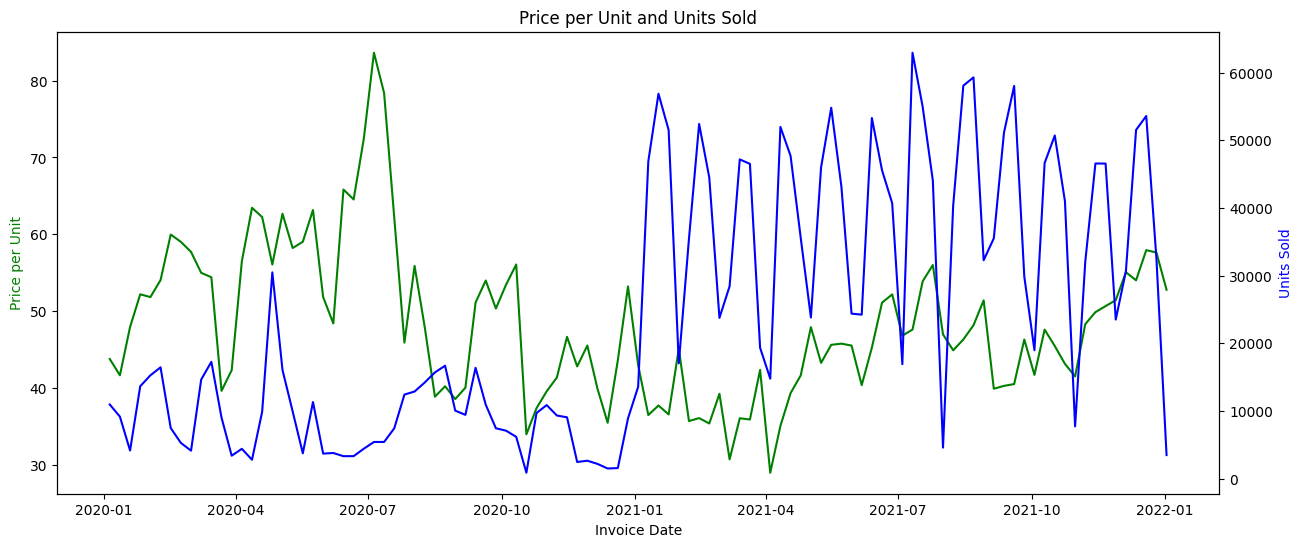

In [8]:
#Let's plot price and sales to see if changes in price could be causing a fluctuation in sales.
price_df = df[['Invoice Date','Price per Unit','Units Sold']]
price_df = price_df.groupby('Invoice Date').agg({
    'Price per Unit':'mean',
    'Units Sold':'sum'
})

fig, ax1 = plt.subplots(figsize=(15, 6))

# Plotting the 'Price per Unit' on the left y-axis
ax1.plot(price_df.index, price_df['Price per Unit'], color='green')
ax1.set_xlabel('Invoice Date')
ax1.set_ylabel('Price per Unit', color='green')

# Creating a second y-axis
ax2 = ax1.twinx()

# Plotting the 'Units Sold' on the right y-axis
ax2.plot(price_df.index, price_df['Units Sold'], color='blue')
ax2.set_ylabel('Units Sold', color='blue')

plt.title('Price per Unit and Units Sold')
plt.show()





In [9]:
#Let's create a final dataframe with all the variables

dummies['Date'] = pd.to_datetime(dummies['Date'])
trend['Semana'] = pd.to_datetime(trend['Semana'])
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])

merged_df = pd.merge(df, dummies, left_on='Invoice Date', right_on='Date', how='left')
merged_df = pd.merge(merged_df,trend,left_on='Invoice Date', right_on='Semana', how='left')
merged_df = merged_df.drop(columns = ['Date', 'Semana'])
merged_df = merged_df.rename(columns={'trend': 'trend'})
df = merged_df
df


,Retailer,Region,State,City,Product,Sales Method,Invoice Date,Price per Unit,Units Sold,Total Sales,Paycheck,Payback,trend
0,Amazon,Midwest,Ohio,Columbus,Men's Apparel,Online,2021-01-24,48.0,252,102392.0,0,0,58
1,Amazon,Midwest,Ohio,Columbus,Men's Apparel,Online,2021-02-14,43.0,572,207502.0,1,0,58
2,Amazon,Midwest,Ohio,Columbus,Men's Apparel,Online,2021-03-14,38.5,488,154181.0,1,0,74
3,Amazon,Midwest,Ohio,Columbus,Men's Apparel,Online,2021-04-11,43.5,476,172992.0,1,0,78
4,Amazon,Midwest,Ohio,Columbus,Men's Apparel,Online,2021-05-09,49.5,576,231174.0,0,0,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,West Gear,West,Washington,Seattle,Women's Street Footwear,Online,2020-07-05,78.0,175,13650.0,0,0,62
7662,West Gear,West,Washington,Seattle,Women's Street Footwear,Online,2020-07-12,73.0,163,11899.0,0,0,65
7663,West Gear,West,Washington,Seattle,Women's Street Footwear,Online,2020-07-19,63.0,135,8505.0,0,0,66
7664,West Gear,West,Washington,Seattle,Women's Street Footwear,Online,2020-07-26,56.0,113,6328.0,0,0,62


## Log-Log Models

In [10]:
#The first model will be done at an aggregated level

df_model_1 = df[['Invoice Date','Price per Unit','Units Sold','Paycheck','Payback','trend']]
grouped_df_1 = df_model_1.groupby(['Invoice Date']).agg({
    'Price per Unit': 'mean',
    'Units Sold': 'sum',
    'Paycheck' : 'mean',
    'Payback' : 'mean',
    'trend' : 'mean'
}).reset_index()

#Create the log sales and log price
grouped_df_1['Log Price'] = np.log(grouped_df_1['Price per Unit'])
grouped_df_1['Log Sales'] = np.log(grouped_df_1['Units Sold'])

summary_data_overall = []

#X variabbles
X = sm.add_constant(grouped_df_1[['Log Price', 'Paycheck', 'Payback','trend']])

y = grouped_df_1['Log Sales']

#fit the model
model_total = sm.OLS(y, X).fit()

#Get coeffs for price
coef_total = model_total.params[1]
p_value_total = model_total.pvalues[1]

summary_data_overall.append({'Coefficient': coef_total, 'P-Value': p_value_total})

summary_overall = pd.DataFrame(summary_data_overall)

summary_overall



,Coefficient,P-Value
0,-1.055043,0.016921


In [11]:
#Model summary

model_summary = model_total.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:              Log Sales   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     13.26
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           1.06e-08
Time:                        18:17:04   Log-Likelihood:                -130.23
No. Observations:                 105   AIC:                             270.5
Df Residuals:                     100   BIC:                             283.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0568      1.790      6.176      0.0

This first model, shows how the only non-significant variable is the dummy "Payback". In this case, price is significant and has a coefficient of -1.05 which will mean that on average, a 1% increase in price, will lead to a 1.05% decrease in sales for Adidas.

In [13]:
#Breakdown by region

df_model_3 = df[['Invoice Date','Product','Region','Price per Unit','Units Sold','Paycheck','Payback','trend']]
grouped_df_region = df_model_3.groupby(['Invoice Date','Product', 'Region']).agg({
    'Price per Unit': 'mean',
    'Units Sold': 'sum',
    'Paycheck' : 'mean',
    'Payback' : 'mean',
    'trend' : 'mean'
}).reset_index()


regions = grouped_df_region['Region'].unique()

#Create the log sales and log price
grouped_df_region['Log Price'] = np.log(grouped_df_region['Price per Unit'])
grouped_df_region['Log Sales'] = np.log(grouped_df_region['Units Sold'])

summary_data_region = []

for region in regions:
    region_df = grouped_df_region[grouped_df_region['Region'] == region]

    #X variabbles
    X = sm.add_constant(region_df[['Log Price', 'Paycheck', 'Payback','trend']])

    y = region_df['Log Sales']

    #fit the model
    model_region = sm.OLS(y, X).fit()

    #Get coeffs for price
    coef_region = model_region.params[1]
    p_value_region = model_region.pvalues[1]

    summary_data_region.append({'Region': region, 'Coefficient': coef_region, 'P-Value': p_value_region})

summary_gender = pd.DataFrame(summary_data_region)

summary_gender

,Region,Coefficient,P-Value
0,Northeast,1.286046,1.654129e-11
1,West,-0.668149,5.431353e-08
2,Southeast,0.224848,3.101410e-02
3,South,0.458127,3.812844e-05
4,Midwest,0.463644,7.496515e-03


The model by region doesn't seem to be feasible, as most of the coefficients result as positive meaning that an increase in price will drive higher sales.

In [16]:
#Breakdown by men and women

df_model_2 = df[['Invoice Date','Product','Price per Unit','Units Sold','Paycheck','Payback','trend']]
df_model_2['Gender'] = np.where((df['Product'] == "Men's Apparel") | (df['Product'] == "Men's Athletic Footwear") | (df['Product'] == "Men's Street Footwear"), "Men","Women")
grouped_df_gender = df_model_2.groupby(['Invoice Date', 'Gender']).agg({
    'Price per Unit': 'mean',
    'Units Sold': 'sum',
    'Paycheck' : 'mean',
    'Payback' : 'mean',
    'trend' : 'mean'
}).reset_index()


genders = grouped_df_gender['Gender'].unique()

#Create the log sales and log price
grouped_df_gender['Log Price'] = np.log(grouped_df_gender['Price per Unit'])
grouped_df_gender['Log Sales'] = np.log(grouped_df_gender['Units Sold'])

summary_data_gender = []

for gender in genders:
    gender_df = grouped_df_gender[grouped_df_gender['Gender'] == gender]

    #X variabbles
    X = sm.add_constant(gender_df[['Log Price', 'Paycheck', 'Payback','trend']])

    y = gender_df['Log Sales']

    #fit the model
    model_gender = sm.OLS(y, X).fit()

    #Get coeffs for price
    coef_gender = model_gender.params[1]
    p_value_gender = model_gender.pvalues[1]

    summary_data_gender.append({'Gender': gender, 'Coefficient': coef_gender, 'P-Value': p_value_gender})

summary_gender = pd.DataFrame(summary_data_gender)

summary_gender

<ipython-input-16-0a4fe08df73a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_2['Gender'] = np.where((df['Product'] == "Men's Apparel") | (df['Product'] == "Men's Athletic Footwear") | (df['Product'] == "Men's Street Footwear"), "Men","Women")


,Gender,Coefficient,P-Value
0,Men,-1.289882,0.007065
1,Women,-1.047343,0.007946


This model by gender shows a higher price sensitivity for men, as a 1% increase would decrease its sales by 1.29% whereas the same price increase for women would lead to a 1.05% decrease in sales.

In [17]:
#Final model doing a deep dive by product

df_model_3 = df[['Invoice Date','Product','Price per Unit','Units Sold','Paycheck','Payback','trend']]
grouped_df_product = df_model_3.groupby(['Invoice Date', 'Product']).agg({
    'Price per Unit': 'mean',
    'Units Sold': 'sum',
    'Paycheck' : 'mean',
    'Payback' : 'mean',
    'trend' : 'mean'
}).reset_index()


products = grouped_df_product['Product'].unique()

#Create the log sales and log price
grouped_df_product['Log Price'] = np.log(grouped_df_product['Price per Unit'])
grouped_df_product['Log Sales'] = np.log(grouped_df_product['Units Sold'])

summary_data_product = []

for product in products:
    product_df = grouped_df_product[grouped_df_product['Product'] == product]

    #X variabbles
    X = sm.add_constant(product_df[['Log Price', 'Paycheck', 'Payback','trend']])

    y = product_df['Log Sales']

    #fit the model
    model_product = sm.OLS(y, X).fit()

    #Get coeffs for price
    coef_product = model_product.params[1]
    p_value_product = model_product.pvalues[1]

    summary_data_product.append({'Product': product, 'Coefficient': coef_product, 'P-Value': p_value_product})

summary_product = pd.DataFrame(summary_data_product)

summary_product

,Product,Coefficient,P-Value
0,Men's Apparel,-0.930941,0.115635
1,Men's Athletic Footwear,-1.199901,0.008142
2,Men's Street Footwear,-1.394970,0.000463
3,Women's Apparel,-1.198234,0.002658
4,Women's Athletic Footwear,-0.734421,0.079578
5,Women's Street Footwear,-1.060455,0.004366


When breaking down by product, most of them show a significant price effect on sales (Men's Apparel didn't show a significant response). With this information we can see that Women's Atheltic Footwear is the least elastic product, being a strong candidate to increase price. On the other side, Men's Street Footwear showed the highest elasticity and could use a price decrease.

